In [2]:
import kaggle
import os
import zipfile
import pandas as pd
import seaborn as sns

In [ ]:
# Download data
COMPETITION_NAME = 'elo-merchant-category-recommendation'
DOWNLOAD_FILES = True
UNZIP_FILES = True

kaggle_api = kaggle.KaggleApi()
kaggle_api.authenticate()

if DOWNLOAD_FILES:
    kaggle_api.competition_download_files(competition=COMPETITION_NAME, path='data', quiet=False)

if UNZIP_FILES:
    for item in os.listdir('data',):
        if item.endswith('zip'):
            file_name = os.path.abspath('data/' + item)
            zip_ref = zipfile.ZipFile(file_name)
            zip_ref.extractall('data/')
            zip_ref.close()
            os.remove(file_name)

In [4]:
# Read data
merchants = pd.read_csv('data/merchants.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
hist_trans = pd.read_csv('data/historical_transactions.csv')

## Data manipulation

In [6]:
train['first_active_year'] = train.first_active_month.str[:4]
train['first_active_month_m'] = train.first_active_month.str[5:]

## Explore train

In [7]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'first_active_year', 'first_active_month_m'],
      dtype='object')

In [23]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_year,first_active_month_m
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,06
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,01
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,08
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,09
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


#### target

In [25]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [29]:
train.groupby(pd.cut(train.target,[-40,-1,0,1,40])).agg('size')

target
(-40, -1]    45742
(-1, 0]      58566
(0, 1]       56709
(1, 40]      40900
dtype: int64

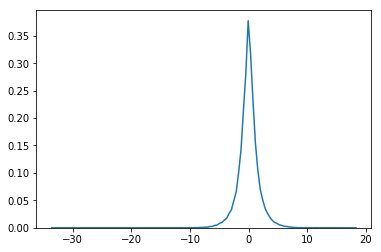

In [24]:
ax = sns.distplot(train[['target']], hist=False,rug = False)

Is normally distributed, half of data is between -1 and 1

#### first_active_month

In [17]:
print(train.first_active_month.min())
print(train.first_active_month.max())

2011-11
2018-02


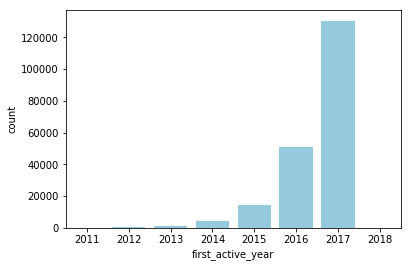

In [28]:
sns.countplot(x='first_active_year', data=train, color='skyblue')

[(-2.5, 2.5)]

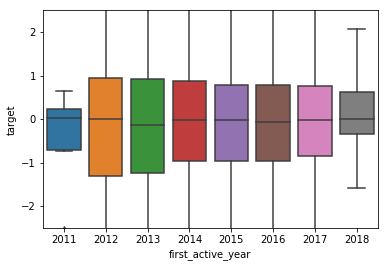

In [41]:
ax = sns.boxplot(x='first_active_year',y='target',data=train,orient='v')
ax.axes.set(ylim=(-2.5,2.5))

#### first_active_month_m

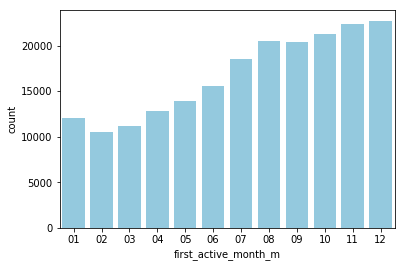

In [108]:
sns.countplot(x='first_active_month_m', data=train, color='skyblue')

In [56]:
year_months = train.groupby(['first_active_year','first_active_month_m']).size()
year_months.groupby('first_active_year').apply(lambda x: 100*x/x.sum()).groupby('first_active_month_m').mean()

first_active_month_m
01    19.471427
02     3.731123
03     4.763369
04     6.154659
05     7.960435
06     7.462820
07     9.419159
08    10.438816
09    10.586543
10    10.746234
11    22.075000
12    13.905195
dtype: float64

#### feature_1

In [109]:
temp = train.groupby('feature_1').size().reset_index(name='count')
temp['proportion'] = temp['count']/temp['count'].sum()
temp

,feature_1,count,proportion
0,1,12037,0.059614
1,2,55797,0.276336
2,3,73573,0.364372
3,4,19885,0.098481
4,5,40625,0.201197


[(-10, 10)]

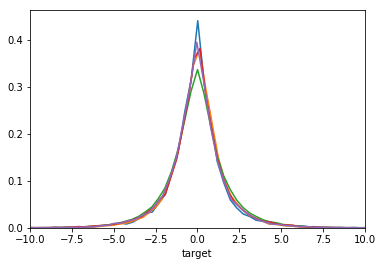

In [119]:
sns.distplot(train[train.feature_1==1].target, hist=False)
sns.distplot(train[train.feature_1==2].target, hist=False)
sns.distplot(train[train.feature_1==3].target, hist=False)
sns.distplot(train[train.feature_1==4].target, hist=False)
sns.distplot(train[train.feature_1==5].target, hist=False).set(xlim=[-10,10])

In [122]:
train.groupby('feature_1').target.agg('describe')

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,-0.315476,3.407106,-33.219281,-0.810411,-0.011003,0.666923,15.011358
2,55797.0,-0.350452,3.756032,-33.219281,-0.806444,0.000000,0.768908,13.592223
3,73573.0,-0.377533,3.834499,-33.219281,-0.956521,-0.036539,0.837927,15.606405
4,19885.0,-0.404652,3.817954,-33.219281,-0.856211,0.000000,0.728345,9.665204
5,40625.0,-0.499879,4.134833,-33.219281,-0.895946,-0.056208,0.692869,17.965068


#### feature_2

In [128]:
temp = train.groupby('feature_2').target.agg('describe').reset_index()
temp['count_proportion'] = temp['count']/sum(temp['count'])
temp

,feature_2,count,mean,std,min,25%,50%,75%,max,count_proportion
0,1,89242.0,-0.398675,3.890548,-33.219281,-0.822850,-0.002394,0.738072,17.965068,0.441974
1,2,74839.0,-0.332899,3.567683,-33.219281,-0.946076,-0.045086,0.799371,15.606405,0.370642
2,3,37836.0,-0.501889,4.269270,-33.219281,-0.902546,-0.033784,0.766570,13.350895,0.187384
